<a href="https://colab.research.google.com/github/JSG1987/Data-Analysis/blob/main/StockMarketAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

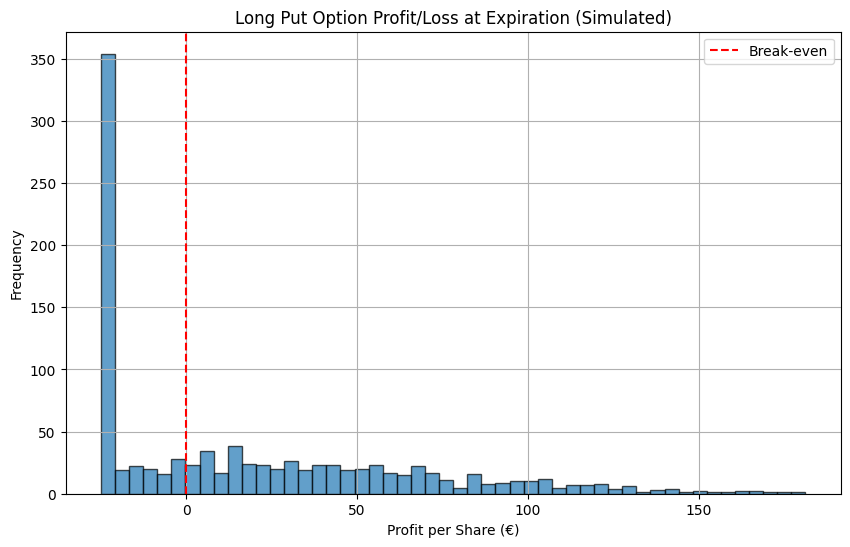

Expected profit: €18.61
Probability of profit: 53.9%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Option and market parameters
current_price = 485.20      # LVMH current stock price in euros
strike_price = 500.00       # You can sell at this price
premium_paid = 25.00        # Cost of the option per share
expiration_days = 90        # 3-month option
simulations = 1000          # Number of price paths
drift = -0.10               # Expected drop (10%) over 3 months
volatility = 0.25           # Annualized volatility

# 2. Simulate future stock prices at expiration (simplified log-normal model)
np.random.seed(42)
T = expiration_days / 365
daily_returns = np.random.normal((drift / 252), (volatility / np.sqrt(252)), (simulations, expiration_days))
price_paths = current_price * np.exp(np.cumsum(daily_returns, axis=1))
final_prices = price_paths[:, -1]

# 3. Calculate payoffs and profit/loss
payoff = np.maximum(strike_price - final_prices, 0)
profit = payoff - premium_paid

# 4. Plotting
plt.figure(figsize=(10, 6))
plt.hist(profit, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Break-even')
plt.title("Long Put Option Profit/Loss at Expiration (Simulated)")
plt.xlabel("Profit per Share (€)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# 5. Summary stats
expected_profit = np.mean(profit)
probability_of_profit = np.mean(profit > 0)

print(f"Expected profit: €{expected_profit:.2f}")
print(f"Probability of profit: {probability_of_profit * 100:.1f}%")


In [ ]:
pip install yfinance matplotlib numpy pandas


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


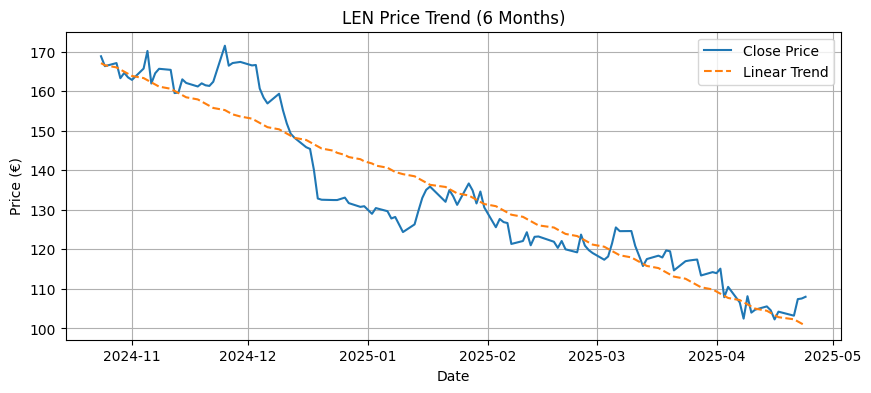

<ipython-input-1-b91a1bdcb18f>:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])


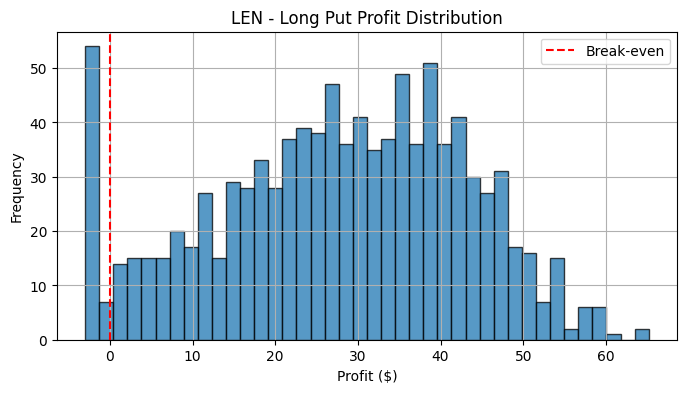


--- Options Strategy Summary ---
Stock  Current Price ($)  Strike Price ($)  Premium ($)  Expected Profit ($) Probability of Profit  Delta    Gamma  Theta ($/day)
  LEN             108.01               110            3                27.58                 94.1% -0.509 0.021754          -8.12


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

# Define tickers and options info
tickers = {
    "LEN": {"ticker": "LEN", "strike_price": 110, "premium_paid": 3,"contracts": 2},
    #"Kering": {"ticker": "KER.PA", "strike_price": 170, "premium_paid": 10},
    #"Hermès": {"ticker": "RMS.PA", "strike_price": 2300, "premium_paid": 60}
}

# Simulation configuration
expiration_days = 90
simulations = 1000
T = expiration_days / 365

results = []

for name, info in tickers.items():
    # Download historical data
    data = yf.download(info['ticker'], period='6mo', interval='1d').dropna()

    # Compute log returns
    data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
    historical_vol = data['LogReturn'].std() * np.sqrt(252)
    historical_drift = data['LogReturn'].mean() * 252

    # Linear regression trendline
    data = data.reset_index()
    data['Day'] = np.arange(len(data))
    reg = LinearRegression().fit(data[['Day']], data['Close'])
    data['Trend'] = reg.predict(data[['Day']])

    # Plot price trend
    plt.figure(figsize=(10, 4))
    plt.plot(data['Date'], data['Close'], label='Close Price')
    plt.plot(data['Date'], data['Trend'], '--', label='Linear Trend')
    plt.title(f"{name} Price Trend (6 Months)")
    plt.xlabel("Date")
    plt.ylabel("Price (€)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Simulate price paths
    current_price = float(data['Close'].iloc[-1])
    daily_drift = historical_drift / 252
    daily_vol = historical_vol / np.sqrt(252)

    daily_returns = np.random.normal(daily_drift, daily_vol, (simulations, expiration_days))
    price_paths = current_price * np.exp(np.cumsum(daily_returns, axis=1))
    final_prices = price_paths[:, -1]

    # Payoff calculation
    payoff = np.maximum(info['strike_price'] - final_prices, 0)
    # Multiply by 100 shares per contract and the number of contracts
    profit = (payoff * 100 * info['contracts']) - (info['premium_paid'] * 100 * info['contracts'])
    profit = payoff - info['premium_paid']
    expected_profit = np.mean(profit)
    prob_profit = np.mean(profit > 0)

    # Option Greeks (approximate Black-Scholes for European put)
    d1 = (np.log(current_price / info['strike_price']) + 0.5 * historical_vol**2 * T) / (historical_vol * np.sqrt(T))
    d2 = d1 - historical_vol * np.sqrt(T)
    delta = -norm.cdf(-d1)
    gamma = norm.pdf(d1) / (current_price * historical_vol * np.sqrt(T))
    theta = (- (current_price * norm.pdf(d1) * historical_vol) / (2 * np.sqrt(T))) / 365

    # Plot Monte Carlo Profit
    plt.figure(figsize=(8, 4))
    plt.hist(profit, bins=40, edgecolor='black', alpha=0.75)
    plt.axvline(0, color='red', linestyle='--', label='Break-even')
    plt.title(f"{name} - Long Put Profit Distribution")
    plt.xlabel("Profit ($)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Store results
    results.append({
        "Stock": name,
        "Current Price ($)": round(current_price, 2),
        "Strike Price ($)": info['strike_price'],
        "Premium ($)": info['premium_paid'],
        "Expected Profit ($)": round(expected_profit, 2),
        "Probability of Profit": f"{prob_profit * 100:.1f}%",
        "Delta": round(delta, 3),
        "Gamma": round(gamma, 6),
        "Theta ($/day)": round(theta*100*info['contracts'], 2)
    })

# Create summary table
df = pd.DataFrame(results)
print("\n--- Options Strategy Summary ---")
print(df.to_string(index=False))


In [ ]:
pip install requests pandas matplotlib

In [ ]:
!pip install requests pandas

In [ ]:
import requests
import pandas as pd

API_KEY = '6VqK7THbKeRB8Nt4BjvibzWCY1ulhUTu'  # 🔑 Paste your API key here
BASE_URL = 'https://financialmodelingprep.com/api/v3'

# List of stock tickers to screen
tickers = ['LEN', 'DHI']  # Add more as needed

def get_ratios(ticker):
    url = f"{BASE_URL}/ratios-ttm/{ticker}?apikey={API_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"❌ Failed to retrieve data for {ticker}")
        return None
    data = response.json()
    print(f"✅ {ticker} raw data:\n", data)  # Add this line
    return data


# Collect data for all tickers
records = []
for ticker in tickers:
    print(f"📊 Getting data for {ticker}...")
    data = get_ratios(ticker)
    if data:
        ratios = data[0]
        records.append({
                  'Ticker': ticker,
                  'CapEx / Revenue': float(ratios.get('capexToRevenueTTM', 0)),
                  'Debt / Equity': float(ratios.get('debtEquityRatioTTM', 0)),
                  'Operating Margin': float(ratios.get('operatingProfitMarginTTM', 0)),
                  'Free Cash Flow Margin': float(ratios.get('freeCashFlowPerShareTTM', 0)),  # use TTM per share as proxy
                  'P/E Ratio': float(ratios.get('peRatioTTM', 0)),
                  'P/B Ratio': float(ratios.get('priceToBookRatioTTM', 0)),
                  'P/S Ratio': float(ratios.get('priceToSalesRatioTTM', 0)),
                  'Dividend Yield': float(ratios.get('dividendYield', 0)),
                  'Free Cash Flow Per Share': float(ratios.get('freeCashFlowPerShareTTM', 0)),
                  'Cash Conversion Cycle': float(ratios.get('cashConversionCycleTTM', 0)),
                  'Interest Coverage': float(ratios.get('interestCoverageTTM', 0)),
                  'PEG Ratio': float(ratios.get('pegRatioTTM', 0))
})

# Convert to DataFrame and sort
df = pd.DataFrame(records)
df.sort_values(by='CapEx / Revenue', ascending=False, inplace=True)
print("\n📈 Screener Results:")
print(df)


📊 Getting data for LEN...
✅ LEN raw data:
 [{'dividendYielTTM': 0.018496254508462037, 'dividendYielPercentageTTM': 1.8496254508462036, 'peRatioTTM': 7.610879261129603, 'pegRatioTTM': -1.8498306543152294, 'payoutRatioTTM': 0.14495629868259782, 'currentRatioTTM': 10.539331214654805, 'quickRatioTTM': 3.140950436004107, 'cashRatioTTM': 1.3064923550035872, 'daysOfSalesOutstandingTTM': 34.929893587727335, 'daysOfInventoryOutstandingTTM': 170.69427468932844, 'operatingCycleTTM': 205.6241682770558, 'daysOfPayablesOutstandingTTM': 23.071842312022678, 'cashConversionCycleTTM': 182.5523259650331, 'grossProfitMarginTTM': 0.14778481818839992, 'operatingProfitMarginTTM': 0.1299145216925908, 'pretaxProfitMarginTTM': 0.13848855484526917, 'netProfitMarginTTM': 0.10438249458537088, 'effectiveTaxRateTTM': 0.23744497572874346, 'returnOnAssetsTTM': 0.1066916483953643, 'returnOnEquityTTM': 0.14216130988390102, 'returnOnCapitalEmployedTTM': 0.1405259477954231, 'netIncomePerEBTTTM': 0.753726506150603, 'ebtPer